In [4]:
using PyPlot
addprocs(4)
@everywhere using DataFrames
#using ProgressMeter

INFO: Loading help data...


In [5]:
@everywhere actions = [:north, :south, :east, :west];

@everywhere type Maze_t
    maze::Matrix{Char}
    sensor_states::Vector{ASCIIString}
    Vw::Matrix{Float64}
    Qw::Array{Float64,3}
    Qs::Matrix{Float64}
    n::Matrix{Float64}
    C::Matrix{Float64}
    numbers::Matrix{Int64}
    state_reward_function::Dict{Char, Float64}
    belief::Vector{Float64}
end

@everywhere type Result
    maze::Maze_t
    values::Vector{Float64}
end

### Initialisation function

In [6]:
@everywhere function get_action_index(symbol::Symbol)
    r = findin(actions, [symbol])
    if length(r) != 1
        return -1
        end
    return r[1]
end

@everywhere function get_sensor_state(maze::Matrix{Char}, i::Int64, j::Int64)
    foldl(string,[maze[i,j], maze[i-1,j+1], maze[i-1,j+1], maze[i, j+1], maze[i+1, j+1], maze[i+1, j], maze[i+1, j-1], maze[i,j-1], maze[i-1,j-1]])
end

@everywhere function get_unique_sensor_states(maze::Matrix{Char})
    sensor_states = []
    for i=2:size(maze)[1] - 1
        for j=2:size(maze)[2] - 1
            if maze[i,j] != '#'
                sensor_state = get_sensor_state(maze, i, j)
                if sensor_state in sensor_states == false
                    sensor_states = [sensor_states, sensor_state]
                end
            end
        end
    end
    sensor_states
end

@everywhere function get_sensor_index(maze::Matrix{Char}, i::Int64, j::Int64, sensor_states::Vector{ASCIIString})
    sensor_state = get_sensor_state(maze, i, j)
    lst = findin(sensor_states, [sensor_state])
    if length(lst) >= 1 && lst[1] > 0
        return lst[1]
    else
        return -1
    end
end

@everywhere function get_state_coordinate(maze::Matrix{Char}, char::Char)
    for i=1:size(maze)[1]
        for j = 1:size(maze)[2]
            if maze[i,j] == char
                return i,j
            end
        end
    end
    return -1, -1
end

@everywhere function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end

@everywhere function create_experiment_setup(definition::String, state_reward_function::Dict{Char,Float64})
    maze          = convert_string_to_string_array(definition)
    sensor_states = get_unique_sensor_states(maze)
    Vw            = zeros(size(maze))
    Qw            = zeros(size(maze)[1], size(maze)[2], 4)
    Qs            = zeros(length(sensor_states),4)
    n             = zeros(size(maze))
    C             = zeros(size(maze))
    numbered_maze = int64(zeros(size(maze)))
    belief        = zeros(length(sensor_states))
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            index = get_sensor_index(maze, i, j, sensor_states)
            if index > 0
                belief[index] = belief[index] + 1.0
                numbered_maze[i,j] = index
            end
        end
    end
    belief = [1.0/v for v in belief]
    return Maze_t(maze, sensor_states, Vw, Qw, Qs, n, C, numbered_maze, state_reward_function, belief)
end

### Plot functions

In [53]:
@everywhere function plot_data(maze::Maze_t)
    s = (size(maze.maze)[2], size(maze.maze)[1] .* 0.3)
    clf()
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    colorbar(imshow(maze.Qs, interpolation="none"))
    title("Q(s,a)")
    
    subplot(122)
    colorbar(imshow(maze.Vw, interpolation="none"))
    xticks([])
    yticks([])
    clim([minimum([0, minimum(maze.Vw)]),1000]) # 1000 is the maximum = V('T')    
    title("V(w)")
end

@everywhere function write_plot_data(maze::Maze_t, filename::String)
    s = (size(maze.maze)[2], size(maze.maze)[1] .* 0.3)
    clf()
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    colorbar(imshow(maze.Qs, interpolation="none"))
    title("Q(s,a)")
    
    subplot(122)
    colorbar(imshow(maze.Vw, interpolation="none"))
    xticks([])
    yticks([])
    title("V(w)")
    clim([minimum([0, minimum(maze.Vw)]),1000]) # 1000 is the maximum = V('T') 
    savefig(filename)
end

### Policy Iteration

In [54]:
@everywhere function policy_iteration!(maze::Maze_t, k::Int64)
    # Q(w,a) = \sum_{w'} p(w'|a) V(w'), where p(w'|a) is a Dirac measure
    for i = 2:size(maze.Vw)[1]-1
        for j = 2:size(maze.Vw)[2] - 1
            maze.Qw[i,j,1] = maze.Vw[i-1, j] - 1.0
            maze.Qw[i,j,2] = maze.Vw[i+1, j] - 1.0
            maze.Qw[i,j,3] = maze.Vw[i,   j+1] - 1.0
            maze.Qw[i,j,4] = maze.Vw[i,   j-1] - 1.0
        end
    end
    
    for s = 1:length(maze.sensor_states)
        for a = 1:4
            maze.Qs[s,a] = 0.0
        end
    end
    
    for i = 2:size(maze.maze)[1] - 1
        for j = 2:size(maze.maze)[2] - 1
            index = get_sensor_index(maze.maze, i, j, maze.sensor_states)
            if index > 0
                for a = 1:4
                    maze.Qs[index, a] = maze.Qs[index, a] + maze.belief[index] * maze.Qw[i,j,a]
                end
            end
        end
    end
    
    for s = 1:length(maze.sensor_states)
        values = DataFrame(VALUES=[v for v in maze.Qs[s,:]], ACTION=actions[1:4], INDICES=[1:4])
        sort!(values, cols = (:VALUES), rev=true)
        if sum(abs(values[:,1])) < 0.001 # randomise action if no values have been aquired so far
            r = randperm(4)
            values[:ACTION]=actions[r]
            values[:INDICES] = r
        end
        values = values[1:minimum([k, size(values)[1]]),:]

        v = values[:,1]
        if sum(v) < 0.1
            v = [1.0/float64(length(v)) for x=1:length(v)]
        else
            rw = sum(v)
            v  = [w / rw for w in v]
        end
        values[:,1] = v
        
        for a = 1:4
            maze.Qs[s,a] = 0.0
        end
        
        for a = 1:size(values)[1]
            maze.Qs[s,values[a,3]] = values[a,1]
        end
    end
   # plot_data(maze, "after policy iteration")
end

### Policy evaluation

In [55]:
@everywhere function policy_evaluation!(maze::Maze_t, T::Int64, R::Int64)
    for i = 1:R
        # randomise start position
        x = 1 + int64(ceil(rand() * size(maze.maze)[1])) - 1
        y = 1 + int64(ceil(rand() * size(maze.maze)[2])) - 1
    
        while maze.maze[x,y] == '#'
            x = 1 + int64(ceil(rand() * size(maze.maze)[1])) - 1
            y = 1 + int64(ceil(rand() * size(maze.maze)[2])) - 1
        end
    
        init_x = x
        init_y = y
        
        if maze.maze[init_x,init_y] in keys(maze.state_reward_function)
            # we are done, if we are on a reward field
            maze.Vw[init_x,init_y] = maze.state_reward_function[maze.maze[init_x,init_y]]
            break
        end

        for i=1:T
            s = get_sensor_index(maze.maze, x, y, maze.sensor_states)
            probabilities = maze.Qs[s,:]
            p = rand()            
            action = actions[end]
            for j = 1:4
                if p < sum(probabilities[1:j])
                    action = actions[j]
                    break
                end
            end

            if action == :north
                if maze.maze[x - 1,y] == 'B'
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x - 1,y] != '#'
                    x = x - 1
                end
            elseif action == :south
                if maze.maze[x + 1,y] == 'B'
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x + 1,y] != '#'
                    x = x + 1
                end
            elseif action == :east
                if maze.maze[x,y + 1] == 'B'
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x,y + 1] != '#'
                    y = y + 1
                end
            elseif action == :west
                if maze.maze[x,y - 1] == 'B'
                    x, y = get_state_coordinate(maze.maze, 'S')
                elseif maze.maze[x,y - 1] != '#'
                    y = y - 1
                end
            end
            
            maze.C[init_x, init_y] = maze.C[init_x, init_y] - 1.0
            if maze.maze[x,y] in keys(maze.state_reward_function)
                maze.C[init_x, init_y] = maze.C[init_x, init_y] + maze.state_reward_function[maze.maze[x,y]]
                break # done. we found a reward
            end
        end
        maze.n[init_x, init_y]  = maze.n[init_x, init_y] + 1.0
        maze.Vw[init_x, init_y] = maze.C[init_x, init_y] / maze.n[init_x, init_y]
    end
   # plot_data(maze, "after policy evaluation\n")
end

### Evaluation

In [58]:
maze_definition = "
#########
###T   B#
##### ###
#B    ###
### #####
###S#####
#########
"

function run_experiment(k::Int64, trials::Int64, iterations::Int64, T::Int64, N::Int64, maze_string::String)
#    pm = Progress(trials * epoch_length, 1)
    results = @parallel (hcat) for i = 1:trials
#        println("Working on trial $i")
        maze = create_experiment_setup(maze_string, ['T' => 1000.0])
        v = zeros(iterations)
        x,y = get_state_coordinate(maze.maze, 'S')
       
        for j = 1:iterations
            policy_evaluation!(maze, T, N)
            policy_iteration!(maze, k)
            v[j] = maze.Vw[x,y]
#            next!(pm)
        end
#        values = values .+ v
        Result(maze, v)
    end
    mazes  = map(r->r.maze,   results)
    values = map(r->r.values, results)
    return mazes, mean(values)
end

run_experiment (generic function with 1 method)

In [59]:
trials = 100
iterations = 2000
initial_positions = 10
mc_path_length = 10
;

Figure(PyObject <matplotlib.figure.Figure object at 0x114fc64d0>)

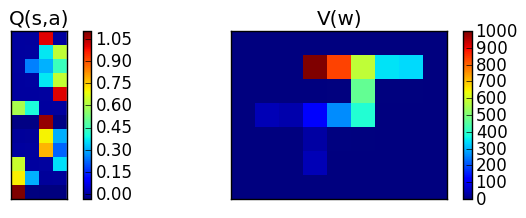

7x9 Array{Float64,2}:
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0     1000.0     836.828  585.642  348.671  340.817  0.0
 0.0   0.0      0.0        0.0       0.0    469.837    0.0      0.0    0.0
 0.0  48.7514  40.6954   111.695   262.384  391.687    0.0      0.0    0.0
 0.0   0.0      0.0       32.6253    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0       48.4275    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0

In [60]:
m4, v4 = run_experiment(4, trials, iterations, mc_path_length, initial_positions, maze_definition)
plot(v4)
plot_data(m4[1])
writecsv("4.csv", v4)
f = open("4.dat", "w")
serialize(f, m4)
close(f)
m4[1].Vw

Figure(PyObject <matplotlib.figure.Figure object at 0x114529e50>)

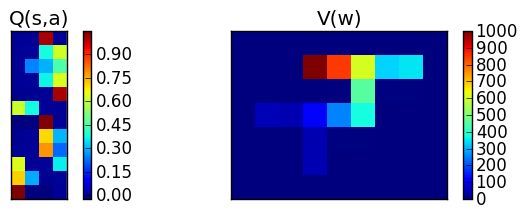

7x9 Array{Float64,2}:
 0.0   0.0      0.0       0.0       0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0    1000.0     849.784  609.993  333.357  354.057  0.0
 0.0   0.0      0.0       0.0       0.0    455.769    0.0      0.0    0.0
 0.0  47.3272  44.908   107.731   257.772  376.243    0.0      0.0    0.0
 0.0   0.0      0.0      45.6418    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0      44.5638    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0       0.0       0.0      0.0      0.0      0.0    0.0

In [61]:
m3, v3 = run_experiment(3, trials, iterations, mc_path_length, initial_positions, maze_definition)
plot(v3)
plot_data(m3[1])
writecsv("3.csv", v3)
f = open("3.dat", "w")
serialize(f, m3)
close(f)
m3[1].Vw

Figure(PyObject <matplotlib.figure.Figure object at 0x113d05d50>)

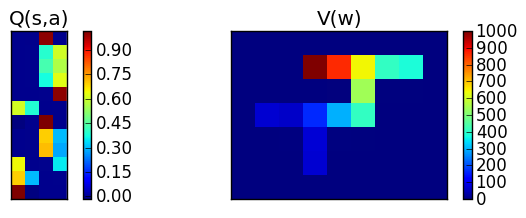

7x9 Array{Float64,2}:
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0     1000.0     865.439  647.09   411.673  385.464  0.0
 0.0   0.0      0.0        0.0       0.0    543.444    0.0      0.0    0.0
 0.0  72.1978  65.4601   164.352   299.384  410.555    0.0      0.0    0.0
 0.0   0.0      0.0       75.0903    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0       72.0505    0.0      0.0      0.0      0.0    0.0
 0.0   0.0      0.0        0.0       0.0      0.0      0.0      0.0    0.0

In [62]:
m2, v2 = run_experiment(2, trials, iterations, mc_path_length, initial_positions, maze_definition)
plot(v2)
plot_data(m2[1])
writecsv("2.csv", v2)
f = open("2.dat", "w")
serialize(f, m2)
close(f)
m2[1].Vw

Figure(PyObject <matplotlib.figure.Figure object at 0x113522950>)

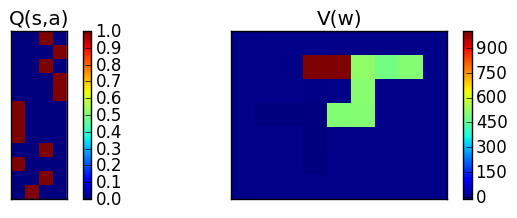

7x9 Array{Float64,2}:
 0.0    0.0    0.0     0.0    0.0      0.0      0.0      0.0    0.0
 0.0    0.0    0.0  1000.0  996.377  519.738  483.557  510.541  0.0
 0.0    0.0    0.0     0.0    0.0    508.945    0.0      0.0    0.0
 0.0  -10.0  -10.0   -10.0  504.103  503.822    0.0      0.0    0.0
 0.0    0.0    0.0   -10.0    0.0      0.0      0.0      0.0    0.0
 0.0    0.0    0.0   -10.0    0.0      0.0      0.0      0.0    0.0
 0.0    0.0    0.0     0.0    0.0      0.0      0.0      0.0    0.0

In [63]:
m1, v1 = run_experiment(1, trials, iterations, mc_path_length, initial_positions, maze_definition)
plot(v1)
plot_data(m1[1])
writecsv("1.csv", v1)
f = open("1.dat", "w")
serialize(f, m1)
close(f)
m1[1].Vw

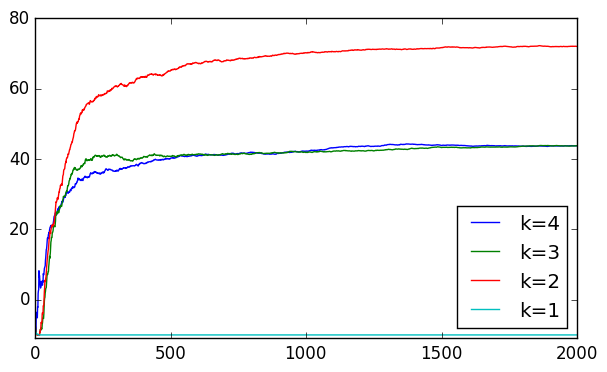

In [68]:
figure(figsize=(7,4))
p4=plot(v4)
p3=plot(v3)
p2=plot(v2)
p1=plot(v1)
ylim([-11, 80])
legend( [p4,p3,p2,p1], ["k=4","k=3","k=2","k=1"], loc=4)

savefig("/Users/zahedi/Dropbox/POMDPs/plots/plot.png")

In [72]:
writecsv("/Users/zahedi/Dropbox/POMDPs/plots/1.csv",v1)
writecsv("/Users/zahedi/Dropbox/POMDPs/plots/2.csv",v2)
writecsv("/Users/zahedi/Dropbox/POMDPs/plots/3.csv",v3)
writecsv("/Users/zahedi/Dropbox/POMDPs/plots/4.csv",v4)

Figure(PyObject <matplotlib.figure.Figure object at 0x113130c90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x118aecd10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11ee38bd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14eeddf90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14dca2710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14c99cc90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x149bb8190>)

Figure(PyObject <matplotlib.figure.Figure object at 0x153ee4f10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1541ba490>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15449c050>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1547a14d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x154a0e290>)

Figure(PyObject <matplotlib.figure.Figure object at 0x154cda2d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x154fba110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1552c0590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15552c350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1557ef450>)

Figure(PyObject <matplotlib.figure.Figure object at 0x155ac0250>)

Figure(PyObject <matplotlib.figure.Figure object at 0x155defdd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x156055350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x156325890>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1565e8a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1569181d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x156b7d5d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x156e4fb10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15711cf50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1573f9ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1576ac850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15797dd90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x157c62850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x157f73ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1581d9b50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x158307490>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15878ead0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x158aabf50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x158d06dd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x158dbee50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1592bcd50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1595dab10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15983e090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x159895590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x159de8fd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15a106d90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15a36d310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15a63d850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15a900b50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15ac34190>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15ae98590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15b169ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15b42e750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15b714a90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15a3b88d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x159125210>)

Figure(PyObject <matplotlib.figure.Figure object at 0x157e061d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x156924610>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1559cf210>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1546c3350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1530f0dd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1529c9c10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x152c0b590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15a87d410>)

Figure(PyObject <matplotlib.figure.Figure object at 0x151f2c150>)

Figure(PyObject <matplotlib.figure.Figure object at 0x151879450>)

Figure(PyObject <matplotlib.figure.Figure object at 0x151388f10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x150fd8bd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x150572f90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1502113d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14fe4a9d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14f988550>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15168c910>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14f881f10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14f4dc850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14eded290>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14eb61f10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14e6e6650>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14e336690>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14de24290>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14da591d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14d742850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14d1fa450>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14f24cdd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14d00a6d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14cce7150>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14c820c10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14c439690>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14bfdc110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14b6ff8d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14b5f8150>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14adac810>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14a954a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14a44ba90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x149f24190>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14ac7ccd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14d64b350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1499138d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14971e7d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14915bf10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x148b8c2d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1484b37d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x147f4edd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x147ab2ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14766a890>)

Figure(PyObject <matplotlib.figure.Figure object at 0x146f77dd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x146bf5350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1466f8890>)

Figure(PyObject <matplotlib.figure.Figure object at 0x146087dd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x147a20090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14b6efd90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x145c03ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1456adad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x144d56e50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1447b4710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1442c4c90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x143a1fa10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1433a7cd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x142f79450>)

Figure(PyObject <matplotlib.figure.Figure object at 0x142c58490>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14230a310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x141d5fd50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1418555d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14137a8d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1409b2e90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x143413f50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x149532e10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1459b7b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1400ef650>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13f9fbf90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13f21c8d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13ed99a90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13e6d5b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13df2be90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13d972990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13d3809d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13cebed50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13c596d90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13c0dc310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13b98bf10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13b3e0850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13ac14f50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13cefb150>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13f13e6d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13b3e07d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13a15d110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x139b8ded0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13955d890>)

Figure(PyObject <matplotlib.figure.Figure object at 0x138fb28d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13893ae50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13836d650>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1381bc910>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13758d990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x136f03b10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13698cfd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1361f8b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1355f0e50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x134ea7e50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13493acd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x134405990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x133caa490>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1334e8f50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x135066790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1380dd0d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13d6b6910>)

Figure(PyObject <matplotlib.figure.Figure object at 0x132f790d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x132aa0dd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1321b6110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13200b410>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1315e1850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x130ea9d90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x130b61f90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13022dc50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12fcb8e90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f519990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12edcd050>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12e908a90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12df7fb90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12d8d8d10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12d18fcd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12cbe8210>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12c46f290>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12bf80490>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12b766b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12b18d990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12b306b10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1309c30d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x137b504d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12a9d8a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12a37ab10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x129cc3b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x129b03090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x128ff64d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x128a1e7d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12844db50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x127d5eb90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1274aa2d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x126fbc390>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1268286d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1261a1ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x125b1b850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12520e110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x124b7ae50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x124631050>)

Figure(PyObject <matplotlib.figure.Figure object at 0x123eb1510>)

Figure(PyObject <matplotlib.figure.Figure object at 0x123891110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x123047150>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1228dcb90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x122678390>)

Figure(PyObject <matplotlib.figure.Figure object at 0x121d5ea10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1238c9310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x126193810>)

Figure(PyObject <matplotlib.figure.Figure object at 0x129a08710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12b298510>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12174ebd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1218a3b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x120a1fbd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12043f110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11fdf5c50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11fa2e890>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11f1335d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11e80d2d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11e3bb590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11de03310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11d8413d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11cff1f10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11c9ef410>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11c0d2b10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11bb6fc90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11b3116d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11ad537d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11a870710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11a0a5b10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11995e990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1192df590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x118cc0c10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x118458ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x117d53ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11788a650>)

Figure(PyObject <matplotlib.figure.Figure object at 0x119e2f0d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11cbecb10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1202a7110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x129d6b3d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11743a710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x116bc1350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1165bd990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1162d1b50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x113d5b810>)

Figure(PyObject <matplotlib.figure.Figure object at 0x113e36410>)

Figure(PyObject <matplotlib.figure.Figure object at 0x113e87450>)

Figure(PyObject <matplotlib.figure.Figure object at 0x112b54d50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11353c410>)

Figure(PyObject <matplotlib.figure.Figure object at 0x114513590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11f9cef50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1173614d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x112b70a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1203afe90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1230e69d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12a72e750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x152f01790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13b488e90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13dfcd9d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13675a750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12bbe8790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12443be90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11ff939d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x119e08750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11acad850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14714e6d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x125fafd50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1229a29d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x140aa6c90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14a0c0510>)

Figure(PyObject <matplotlib.figure.Figure object at 0x15b664290>)

Figure(PyObject <matplotlib.figure.Figure object at 0x113d84250>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1194cc810>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1455bd850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1407c5ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1314ecb50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13368ee90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x127d88850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x124c36bd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x120743b50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11d816350>)

Figure(PyObject <matplotlib.figure.Figure object at 0x115c45ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1243f3f50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1338e9dd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f7d3e50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1423b1d50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x142124b10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x139369090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x136ce8590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12b56da50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x125942d90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12542b310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11f3d4110>)

Figure(PyObject <matplotlib.figure.Figure object at 0x118792fd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11be1fd90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14d581310>)

Figure(PyObject <matplotlib.figure.Figure object at 0x120fde850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x143157b50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1406d7190>)

Figure(PyObject <matplotlib.figure.Figure object at 0x138115590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x132f25ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f2c0750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12da85a90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12a296810>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11d9a3bd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1385796d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11f38a510>)

Figure(PyObject <matplotlib.figure.Figure object at 0x137228650>)

Figure(PyObject <matplotlib.figure.Figure object at 0x122351bd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x112f3fb50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x112d38090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11af62510>)

Figure(PyObject <matplotlib.figure.Figure object at 0x146b9c850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x139daaad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14297b090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13d9b2510>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13d97ca50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13dc236d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x137ef8a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x134ed6790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13197fe10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x128121710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x123e81d90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11c107a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x117ff5a50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x146e38710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x151e98d90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x144fc2a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13ac6ea50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x139ba4710>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13584cd90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f674a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f93af50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12718e990>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12045fe10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x120a93c90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x113d2d1d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11a1e5c10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1162809d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12885df10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x150a3afd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1441a4c10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13c0119d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x145072f10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1369ebfd0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13a6fec10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x149684ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x116987e10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x136168250>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1199bbb90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13ea0b550>)

Figure(PyObject <matplotlib.figure.Figure object at 0x113324b90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x134b91ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f577790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x121808e10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x121abca90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11c6df290>)

Figure(PyObject <matplotlib.figure.Figure object at 0x119391a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x149e22e90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1384ccd10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11ac2b590>)

Figure(PyObject <matplotlib.figure.Figure object at 0x151ab4c90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x149de6a50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13ebed4d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14446d650>)

Figure(PyObject <matplotlib.figure.Figure object at 0x133fdba90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13218d090>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12f29b250>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12cfc5790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12301e910>)

Figure(PyObject <matplotlib.figure.Figure object at 0x120cccf50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11b1ce4d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x116df9a10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x14770de90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11838c9d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x150125750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13f882790>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1351c0e90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x136bc89d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12fe57750>)

Figure(PyObject <matplotlib.figure.Figure object at 0x137f1d850>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1274306d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x124000d50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12104e9d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x11ee6df90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x115b6ce50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1186f5ed0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13cfe4c50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1143c8f90>)

Figure(PyObject <matplotlib.figure.Figure object at 0x144409950>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1395dded0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x139df3c50>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1343474d0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x13b6afe10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1245a4ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1422bc610>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12204fd10>)

Figure(PyObject <matplotlib.figure.Figure object at 0x1433f7ad0>)

Figure(PyObject <matplotlib.figure.Figure object at 0x121ac5150>)

Figure(PyObject <matplotlib.figure.Figure object at 0x12e1ab450>)

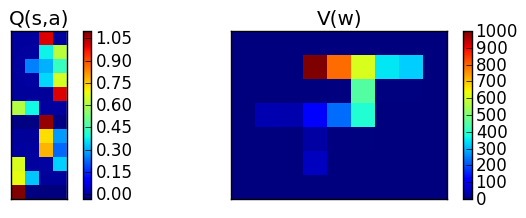

In [70]:
for i = 1:length(m1)
    write_plot_data(m1[i], "/Users/zahedi/Dropbox/POMDPs/plots/V1_$i.png")
    write_plot_data(m2[i], "/Users/zahedi/Dropbox/POMDPs/plots/V2_$i.png")
    write_plot_data(m3[i], "/Users/zahedi/Dropbox/POMDPs/plots/V3_$i.png")
    write_plot_data(m4[i], "/Users/zahedi/Dropbox/POMDPs/plots/V4_$i.png")
end

Figure(PyObject <matplotlib.figure.Figure object at 0x1460a5310>)

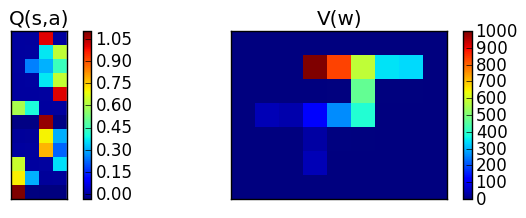

PyObject <matplotlib.text.Text object at 0x124b4be10>

In [71]:
plot_data(m4[1])